In [1]:
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
import numpy as np
import random as rn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile


%matplotlib notebook

## Traditional NLP

### wordNet

wordNet - a thesaurus containing lists of synonym sets and hypernyms ("is a" relationships).

But WordNet never works that well.
- missed nuances
- missed new words (wicked, badass, ninja, etc.)
- subjective
- requires human labro to create and adapt
- can't compute accurate word similarity
- in additional with one-hot-encoding it gives very huge space of similarity

synonym sets containing "good"

In [2]:
poses = {
    'n': 'noun',
    'v': 'verb',
    's': 'adj (s)',
    'a': 'adj',
    'r': 'adv'
}

for synset in wn.synsets('good'):
    pos = poses[synset.pos()]
    lemas = ', '.join(l.name() for l in synset.lemmas())
    print(f'{pos}: {lemas}')

noun: good
noun: good, goodness
noun: good, goodness
noun: commodity, trade_good, good
adj: good
adj (s): full, good
adj: good
adj (s): estimable, good, honorable, respectable
adj (s): beneficial, good
adj (s): good
adj (s): good, just, upright
adj (s): adept, expert, good, practiced, proficient, skillful, skilful
adj (s): good
adj (s): dear, good, near
adj (s): dependable, good, safe, secure
adj (s): good, right, ripe
adj (s): good, well
adj (s): effective, good, in_effect, in_force
adj (s): good
adj (s): good, serious
adj (s): good, sound
adj (s): good, salutary
adj (s): good, honest
adj (s): good, undecomposed, unspoiled, unspoilt
adj (s): good
adv: well, good
adv: thoroughly, soundly, good


e.g hypernyms of "panda"

In [3]:
panda = wn.synset('panda.n.01') # lemma, pos, synset_index_str 
hyper = lambda s: s.hypernyms()
list(panda.closure(hyper))

[Synset('procyonid.n.01'),
 Synset('carnivore.n.01'),
 Synset('placental.n.01'),
 Synset('mammal.n.01'),
 Synset('vertebrate.n.01'),
 Synset('chordate.n.01'),
 Synset('animal.n.01'),
 Synset('organism.n.01'),
 Synset('living_thing.n.01'),
 Synset('whole.n.02'),
 Synset('object.n.01'),
 Synset('physical_entity.n.01'),
 Synset('entity.n.01')]

## Distributional symantics
A word's meaning is given by the words that frequently appear close-by

> "You shall know a word by the company it keeps" (J.R. Firth 1957)

build a sense vector for each word, chosen so that it's similar to vectors of words that appear in similar context.

`Word vectors` -> `word embeddings`, or `word representation`

### Word2Vec
Mikolov 2013

_`corpus` one body of text, `corpora` multiple bodies of text, because it is latin_

For a center word $c$ and a context word $o$

$$
P(o|c) = \frac{\exp(u_0^T v_c)}{\sum_{W \in{V}}{\exp(u_w^T v_c)}}
$$

- $v_w$ when $w$ is a center word
- $u_w$ when $w$ is a context word

similarty between words / normalize over entire vocab and give probability distribution.

It is softmax function, which gives prob distribution


$$
\frac{\delta}{\delta{v_c}} \log{P(o|c)} = u_0 - \sum_{x \in{V}} p(x|c) u_x
$$

$u_0$ obsorbe representation of context word and we subtruction from that the context should look like (other words on their probability) - expected context word

TODO: try to do the same for $u_c$ (context word vector)

## Gensim
starts from LDA-style (Latent Dirichlet allocation) topics models and grew into SVD (Singular value decomposition) and neural word representation

ME: lets use pretrained model from gensim [repos](https://github.com/RaRe-Technologies/gensim-data). We use the same model which is used in lectures

In [5]:
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
model = api.load('glove-wiki-gigaword-100')  # download the model and return as object ready for use
model.most_similar('cat')

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[('dog', 0.8798074722290039),
 ('rabbit', 0.7424426674842834),
 ('cats', 0.7323004007339478),
 ('monkey', 0.7288709878921509),
 ('pet', 0.7190139889717102),
 ('dogs', 0.7163872718811035),
 ('mouse', 0.6915250420570374),
 ('puppy', 0.6800068020820618),
 ('rat', 0.6641027331352234),
 ('spider', 0.6501135230064392)]

In [6]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

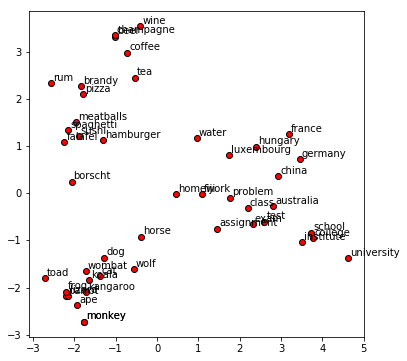

In [7]:
display_pca_scatterplot(model, 
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

In [8]:
rn.sample([word for word in model.vocab if 'woman' in word], 10)

['camerawoman',
 'henchwoman',
 'womaniser',
 'fisherwoman',
 'all-woman',
 'womanism',
 'congresswoman',
 'cavewoman',
 'markswoman',
 'sportswoman']

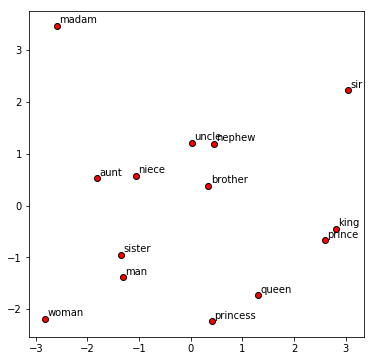

In [9]:
# display_pca_scatterplot(model, rn.sample([word for word in model.vocab if 'bio' in word], 10))
display_pca_scatterplot(model, [
    'man','woman',
    'king', 'queen',
    'brother', 'sister',
    'nephew', 'niece',
    'prince', 'princess',
    'sir', 'madam',
    'uncle', 'aunt',
])

- Skip Grams (SG) - predict context words give center word
- Continues Bag of Words (CBOW) - predict center word from (bag of) context words

- Negative sampling vs Naive softmax
> Main idea: train binary logistic regressions for a true pair (center word and word in its context window) versus several noise pairs (the center word paired with a random word)

$$
J_{neg - sample}(o, v_c, U) = - \log{(\sigma(u_0^T v_c)} - \sum_{k=1}^{K}\log{(\sigma(-u_k^T v_c))}
$$
- take k negative samples (using word probabilities)
- maximize probability that real outside word appears, minimize prob. that random words appear around center word
- $P(w)=U(w)^{3/4} / Z$, where normalization term $Z = \sum U(w_i)$. What makes unigram distribution $U(w)$ raised to the 3/4 power, and makes less frequent words be sampled more often


## Count based technics

Word2vec technics similar to traditional
- `window`- create matrix of count how many times each word co-occurrence with other and captures both syntactic (POS) and
semantic information
- `document` leads to Latent Semantic Analysis

### dimensionality reduction
use can use Singular Value Decomponsition (SVD) of co-occurrence matrix X. And get only few the most important k singular values, in order to generalize. But it is expensive to cumpute for big matrixes like X

### Example

In [10]:
sentenses = [
    'I like deep learning',
    'I like NLP',
    'I enjoy flying',
    'I like swimming'
]

words = list({w for s in sentenses for w in s.split()})
print(words)
tuples = [(w1, w2) for s in sentenses for w1, w2 in zip(s.split(), s.split()[1:])]
print(tuples)

['flying', 'I', 'NLP', 'deep', 'learning', 'swimming', 'like', 'enjoy']
[('I', 'like'), ('like', 'deep'), ('deep', 'learning'), ('I', 'like'), ('like', 'NLP'), ('I', 'enjoy'), ('enjoy', 'flying'), ('I', 'like'), ('like', 'swimming')]


In [11]:
X = np.zeros((len(words), len(words)))
for w1, w2 in tuples:
    X[words.index(w1), words.index(w2)]+=1
    X[words.index(w2), words.index(w1)]+=1    
X

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 3., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 3., 1., 1., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0.]])

now is time for singular value decomposition

[ 3.59290673e+00  3.59290673e+00  1.15708206e+00  1.15708206e+00
  8.67284475e-01  8.67284475e-01  5.60343953e-17 -0.00000000e+00]


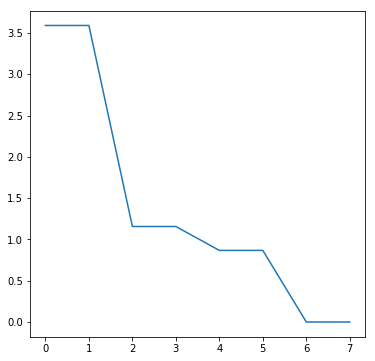

In [12]:
U, s, Vh = np.linalg.svd(X, full_matrices=False)
plt.figure(figsize=(6,6))
print(s)
plt.plot(s);

lets draw it for 2 the most important singular values

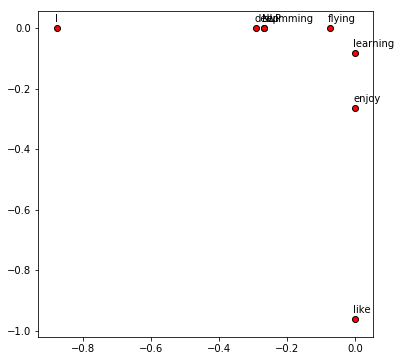

In [13]:
plt.figure(figsize=(6,6))
coords = np.array([[U[idx, 0], U[idx, 1]] for idx, word in enumerate(words)])
plt.scatter(coords[:,0], coords[:,1], edgecolors='k', c='r')
for idx, word in enumerate(words):
    plt.text(U[idx, 0] - 0.005, U[idx, 1] + 0.02, word)

### how can we improve it
- the problem of frequent words (the, he, has,...) which have too much impact. use "sealing" function $min(X,t)$, with $t \approx 100$, or ignore them
- ramped windows that count closer words more
- use Pearson correlations instead of counts, then set negative values to 0

Analogy as test coin to Rohde (2005)

### Count based vs direct prediction

#### Ccount based
- LSA, HAL,
- COALS, Hellinger-PCA
- pros:
    - Fast train
    - Effcient usage of statistics
- cons:
    - Primarily used to capture word similarity
    - Disproportionate importance given to large counts

#### direct prediction
- Skip-gram/CBOW
- NNLM, HLBL, RNN
- procs:
    - Generate improved performance on other tasks
    - Can capture complex patterns beyond word similarity
    - could train fast and parallel
- cons:
    - Scales with corpus size
    - Inefficient usage of statistics

## Encoding meaning in vector differences
### Combine both count based and direct prediction
Ratios of co-occurrence probabilities can encode meaning components. Divide probability different words in context of word `a` and word `b`.

### How to capture ratios of co-occurrence probabilities as linear meaning components in a word vector space?

Log-bilinear model. Probability of word `i`, given word `j`:
$$
w_i \cdot w_j = \log{P(i|j)}
$$
then we can have vector differences between words `a` and `b`
$$
w_x \cdot (w_a - w_b) = \log{\frac{P(x|a)}{P(x|b)}}
$$

### GloVe

$$
J = \sum_{i,j=1}^{V}f(X_{ij}) (w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log{X_{ij}})^2
$$

- Fast training
- scalable to huge corpa
- Good performance even with small corpus and small vectors

So dot product of $w$ should be close similar to $X$ co-occurance probability, but with some bies for both words based on popularity.

$f$ should capping $X$ on some max value.

## How to evaluate word vectors?
- intrinsic
    - Evaluation on a specific/intermediate subtask
    - Fast to compute
    - Helps to understand that system
    - Not clear if really helpful unless correlation to real task is established
- extrinsic
    - Evaluation on a real task
    - Can take a long time to compute accuracy
    - Unclear if the subsystem is the problem or its interaction or other subsystems
    - If replacing exactly one subsystem with another improves accuracy Winning!
    - eg. named entity recognition: finding a person, organization or location

### Intrinsic word vector evalution
#### Word vector analogies
cosine distance and angle between vectors of words

`a:b :: c:?`
(`man:woman :: king:?`)


$$
d = argmax_{i} \frac{(x_b - x_a + x_c)^T x_i}{||x_b - x_a + x_c||}
$$
- Evaluate word vectors by how well their cosine distance after addition captures intuitive semantic and syntactic analogy questions
- Trick: Discarding the input words from the search!
- Problem: What if the information is there but not linear?

Text(0.5, 1.0, 'analogies graph, based on "glove-wiki-gigaword-100" model')

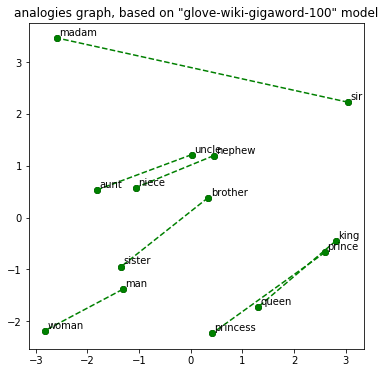

In [43]:
def display_pca_scatterplot_of_pair_words(model, word_analogies, figsize=(6,6)):
    def get_seq(a):
        if isinstance(a, dict):
            return a['seq']
        else:
            return a
    words = [w for analog_sequence in word_analogies for w in get_seq(analog_sequence)]
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=figsize)
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

    for analog_sequence in word_analogies:
        if isinstance(analog_sequence, dict):
            color = analog_sequence['color']
            analog_sequence = analog_sequence['seq']
            print('custom seq', color)
        else:
            color = 'green'
        coords = np.array(list(zip(*(twodim[words.index(w)].tolist() for w in analog_sequence))))
#         idx_a = words.index(w_a)
#         idx_b = words.index(w_b)
# #         Arrow doesn't look nice as simple dash lines
# #         x_a, y_a = twodim[idx_a]
# #         x_b, y_b = twodim[idx_b]
# #         plt.arrow(x_a, y_a, x_b - x_a, y_b - y_a, head_width=0.05, head_length=0.1)
#         coords = list(zip(twodim[idx_a], twodim[idx_b]))
        plt.plot(
            coords[0],
            coords[1],
            scalex=False, scaley=False,
            color=color, marker='o', linestyle='dashed'
        )

display_pca_scatterplot_of_pair_words(model, [
    ('man','woman'),
    ('king', 'queen'),
    ('brother', 'sister'),
    ('nephew', 'niece'),
    ('prince', 'princess'),
    ('sir', 'madam'),
    ('uncle', 'aunt'),
])
plt.title('analogies graph, based on "glove-wiki-gigaword-100" model')

custom seq orange
custom seq red


Text(0.5, 1.0, 'superlatives graph, based on "glove-wiki-gigaword-100" model')

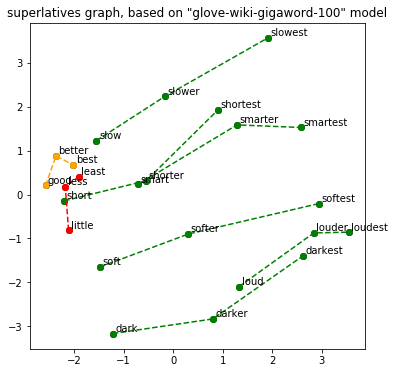

In [15]:
display_pca_scatterplot_of_pair_words(model, [
#     ('small', 'smaller', 'smallest'),
    ('slow', 'slower', 'slowest'), 
    ('short', 'shorter', 'shortest'),
#     ('strong', 'stronger', 'strongest'),    
    ('soft', 'softer', 'softest'),     
    ('dark', 'darker', 'darkest'),
    ('smart', 'smarter', 'smartest'),
    ('loud', 'louder', 'loudest'),
    # irregular comparatives don't do as well as regular
    {'seq': ('good', 'better', 'best'), 'color': 'orange'},
    {'seq': ('little', 'less', 'least'), 'color': 'red'}
])
plt.title('superlatives graph, based on "glove-wiki-gigaword-100" model')

We have something different with irregular comparative and superlative forms

custom seq blue


Text(0.5, 1.0, 'superlatives graph, based on "glove-wiki-gigaword-100" model')

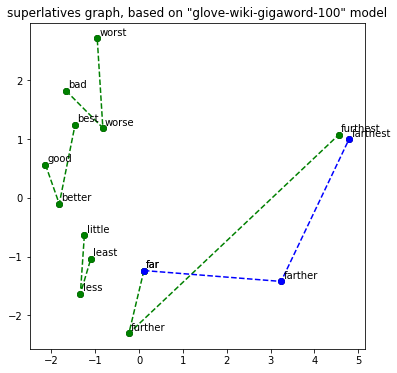

In [16]:
display_pca_scatterplot_of_pair_words(model, [
    ('good', 'better', 'best'),
    ('little', 'less', 'least'),
    ('bad', 'worse', 'worst'),
    ('far', 'further', 'furthest'),
    {'seq': ('far', 'farther', 'farthest'), 'color': 'blue'}, # different form
])
plt.title('superlatives graph, based on "glove-wiki-gigaword-100" model')

Data set with analogies `word2vec questions-words.txt` but it could be googled, for example here <https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt>.

The problem is different cities may have same name

### lets take a look on other prebuilt models from Gensim
initially I have used `glove-wiki-gigaword-100` _Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)_.

But there are alternatives (they are much bigger):
- `glove-wiki-gigaword-300` with bigger vector size _Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)_
- `fasttext-wiki-news-subwords-300` _Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)_
- `word2vec-google-news-300` _Google News (about 100 billion words)_
- `conceptnet-numberbatch-17-06-300` _ConceptNet, word2vec, GloVe, and OpenSubtitles 2016_

In [18]:
fasttext_wiki_news_subwords_300_model = api.load('fasttext-wiki-news-subwords-300')
fasttext_wiki_news_subwords_300_model.most_similar('cat')

[==================================================] 100.0% 958.5/958.4MB downloaded


/usr/local/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[('cats', 0.8368596434593201),
 ('housecat', 0.7674711346626282),
 ('-cat', 0.7602992057800293),
 ('dog', 0.7502298355102539),
 ('kitten', 0.7480818033218384),
 ('feline', 0.7353992462158203),
 ('super-cat', 0.7305205464363098),
 ('supercat', 0.7163283824920654),
 ('pet', 0.7090284824371338),
 ('moggy', 0.7057286500930786)]

In [21]:
glove_wiki_gigaword_300_model = api.load('glove-wiki-gigaword-300')
glove_wiki_gigaword_300_model.most_similar('cat')

/usr/local/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[('dog', 0.6816747188568115),
 ('cats', 0.6815836429595947),
 ('pet', 0.5870364904403687),
 ('dogs', 0.540766716003418),
 ('feline', 0.48979705572128296),
 ('monkey', 0.48794347047805786),
 ('horse', 0.4732130467891693),
 ('pets', 0.4634858965873718),
 ('rabbit', 0.4608757495880127),
 ('leopard', 0.4585462808609009)]

hm, on irregular words look even worse on big "fasttext-wiki-news-subwords-300"

custom seq blue


Text(0.5, 1.0, 'superlatives graph, based on "fasttext-wiki-news-subwords-300" model')

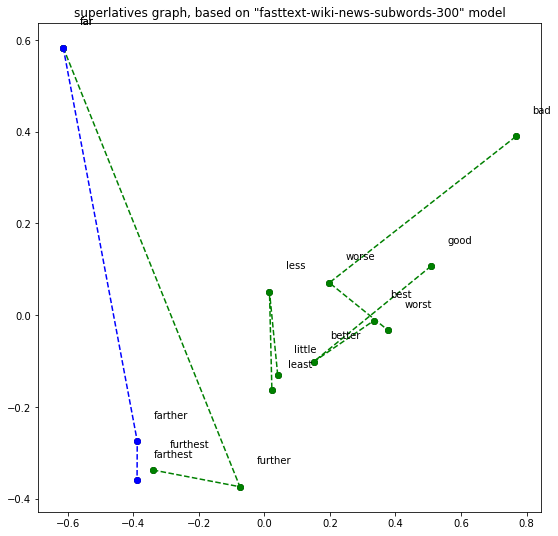

In [49]:
display_pca_scatterplot_of_pair_words(fasttext_wiki_news_subwords_300_model, [
    ('good', 'better', 'best'),
    ('little', 'less', 'least'),
    ('bad', 'worse', 'worst'),
    ('far', 'further', 'furthest'),
    {'seq': ('far', 'farther', 'farthest'), 'color': 'blue'}, # different form
], figsize=(9,9))
plt.title('superlatives graph, based on "fasttext-wiki-news-subwords-300" model')

custom seq orange
custom seq red


Text(0.5, 1.0, 'superlatives graph, based on "fasttext-wiki-news-subwords-300" model')

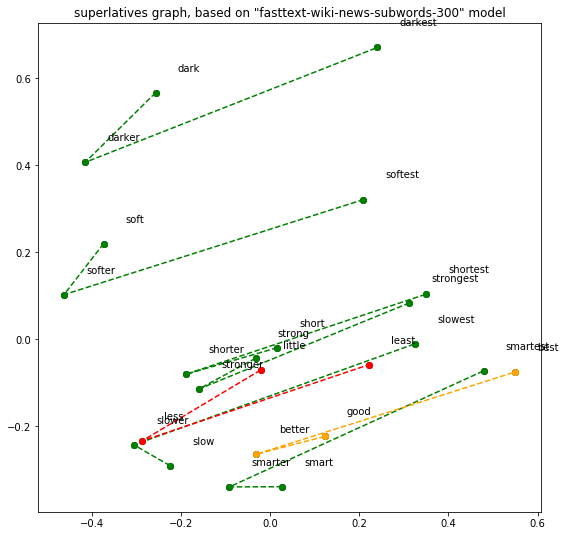

In [48]:
display_pca_scatterplot_of_pair_words(fasttext_wiki_news_subwords_300_model, [
#     ('small', 'smaller', 'smallest'),
    ('slow', 'slower', 'slowest'), 
    ('short', 'shorter', 'shortest'),
    ('strong', 'stronger', 'strongest'),    
    ('soft', 'softer', 'softest'),     
    ('dark', 'darker', 'darkest'),
    ('smart', 'smarter', 'smartest'),
#     ('loud', 'louder', 'loudest'),
    # irregular comparatives don't do as well as regular
    {'seq': ('good', 'better', 'best'), 'color': 'orange'},
    {'seq': ('little', 'less', 'least'), 'color': 'red'}
], figsize=(9,9))
plt.title('superlatives graph, based on "fasttext-wiki-news-subwords-300" model')

custom seq blue


Text(0.5, 1.0, 'superlatives graph, based on "glove-wiki-gigaword-300" model')

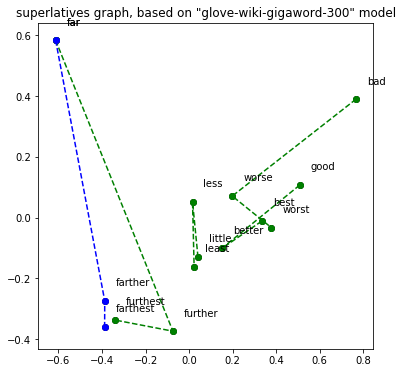

In [23]:
display_pca_scatterplot_of_pair_words(glove_wiki_gigaword_300_model, [
    ('good', 'better', 'best'),
    ('little', 'less', 'least'),
    ('bad', 'worse', 'worst'),
    ('far', 'further', 'furthest'),
    {'seq': ('far', 'farther', 'farthest'), 'color': 'blue'}, # different form
])
plt.title('superlatives graph, based on "glove-wiki-gigaword-300" model')

custom seq orange
custom seq red


Text(0.5, 1.0, 'superlatives graph, based on "glove-wiki-gigaword-300" model')

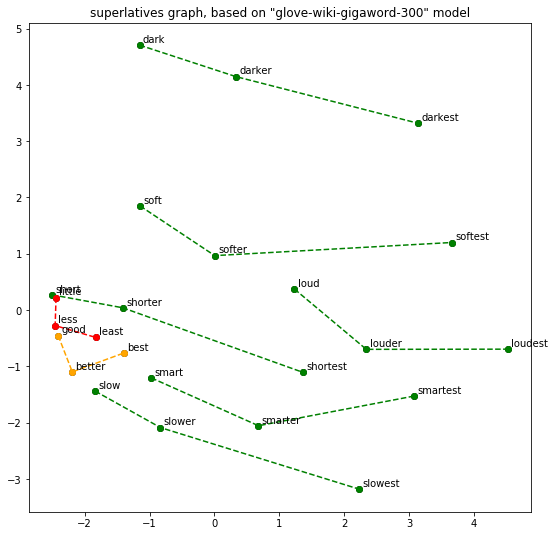

In [47]:
display_pca_scatterplot_of_pair_words(glove_wiki_gigaword_300_model, [
#     ('small', 'smaller', 'smallest'),
    ('slow', 'slower', 'slowest'), 
    ('short', 'shorter', 'shortest'),
#     ('strong', 'stronger', 'strongest'),    
    ('soft', 'softer', 'softest'),     
    ('dark', 'darker', 'darkest'),
    ('smart', 'smarter', 'smartest'),
    ('loud', 'louder', 'loudest'),
    # irregular comparatives don't do as well as regular
    {'seq': ('good', 'better', 'best'), 'color': 'orange'},
    {'seq': ('little', 'less', 'least'), 'color': 'red'}
], figsize=(9,9))
plt.title('superlatives graph, based on "glove-wiki-gigaword-300" model')

### Humans judgements of similarity
Word vector distances and their correlation with human judgments. Example dataset: [WordSim353](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/)

### The Problem of sense ambiguity
many popular of old words have multiple meanings
Do we capture all meanings?

#### Improving Word Representations Via Global Context
_And Multiple Word Prototypes (Huang et al. 2012)_.

Cluster word windows around words, retrain with each word assigned to multiple different clusters bank1, bank2, etc.
And map each common work to its specific meaning before training.

#### Linear Algebraic Structure of Word Senses, with
_Applications to Polysemy (Arora, …, Ma, …, TACL 2018)_.

Different senses of a word reside in a linear superposition (weighted sum) in standard word embeddings like word2vec

for example

$$
v_{pike} = \alpha_1 v_{pike_{1}} + \alpha_2 v_{pike_{2}} + \alpha_3 v_{pike_{3}}
$$

$$
\alpha_1 = \frac{f_1}{f_1 + f_2 + f_3}
$$
, $f$ - frequency of word.

And it works because matrix of co-occurance is sparse. Because of ideas from sparse coding you can actually separate out the senses (providing they are relatively common)

# TODO: Questions
- what the difference between GloVe and Word2Vec? Glove uses Co-occurance matrix
- how does they related to [Count-based-vs-direct-prediction](http://eugene-ai.local:8888/notebooks/courses/cs224n_nlp_with_deep_learning_2019/src/notebooks/01-intro.ipynb#Count-based-vs-direct-prediction)? Yes
- does it mean that `Word2Vec + (count based method) = GloVe`? It seems so.
- What is Fasttext?

### Statistical language model
$$
\hat{P}(w_i^T) = \prod_{i=0}^{T}\hat{P}(w_i|w_1^{i-1}),
$$
where $w_i$ word and $w_i^j = (w_i,w_{i+1},...w_{j})$.

Probability of given sequence of words $w_i^T$ is product of probobilities of one of word in condition of previous ones.

**The Problem**: You always have some sequence of words, which you don't have samples, so you can assign probability


## Neural Networks
Learn conventional params ( $W$ ) representation learning (how do we embed into word vector)

### Named Entity Recognition
Find and classify names in text.

We predict entities by classifying words in context and then extracting as word subsequences.

`Foreign [B-ORG] Ministry [I-ORG] spokemen[O] Shen[B-PER] Guofang[I-PER] told[O] Reuter[B-ORG] that[O]`

#### Window classification
Train softmax classifier to classify a center word by taking concatination of word vectors surrounding it in a window

with $x = x_{window}$

$$
\hat{y}_y = p(y|x) = \frac{exp(W_y \cdot x)}{\sum_{c=1}^{C} exp(W_c \cdot x)}
$$

with cross entropy error as before:

$$
J(\theta) = \frac{1}{N} \sum_{i=1}^{N}{-\log{(\frac{e^{f_{y_i}}}{\sum_{c=1}^{C} e^{f_{c}}})}}
$$

where

$$
f_{y_i} = W_y \cdot x
$$

Approach similar to word2vec, but supervised

$x$ - word with window

layer 1
$$
z = W x + b
$$
$$
a = f(z)
$$
layer 2
$$
s = U^Ta
$$

$s$ - score

##### Hints
Sample several corrupt windows per true one. Sum over all training windows, Similar to negative sampling in word2vec


$$
\frac{\partial}{\partial{u}}(u^Th) = h^T
$$

$$
\frac{\partial{s}}{\partial{b}} = \frac{\partial{s}}{\partial{a}} \frac{\partial{a}}{\partial{z}} \frac{\partial{z}}{\partial{b}}
$$

$$
\frac{\partial{s}}{\partial{a}} = \frac{\partial{U^Ta}}{\partial{a}} = U^T
$$

$$
\frac{\partial{a}}{\partial{z}} = \frac{\partial{f(z)}}{\partial{z}} = diag(f'(z))
$$

$$
\frac{\partial{z}}{\partial{b}} = \frac{\partial{Wx + b}}{\partial{b}} = I
$$

so as reult:
$$
\frac{\partial{s}}{\partial{b}} = U^T diag(f'(z))
$$

$$
\frac{\partial{s}}{\partial{W}} = \frac{\partial{s}}{\partial{a}} \frac{\partial{a}}{\partial{z}} \frac{\partial{z}}{\partial{W}}
$$

All the same except the last part

$$
\frac{\partial{z}}{\partial{W}} = \frac{\partial{Wx + b}}{\partial{W}} = x
$$

as result:
$$
\frac{\partial{s}}{\partial{W}} = U^T diag(f'(z)) x
$$

## Dependency Parsing (Lec.5)

Phrase structure grammar (context-free grammars) (CFGs).

### Prepositional Phrase (PP) attachment ambiguity
(eg. "Science count whales from space", could mean "count from space", or "whales from space")

In general there could be $ C_n = (2n)! / [(n+1)!n!]$ combinations (Catalan numbers)

$$
C_0 = 1
$$
$$
C_n = \frac{2(2n - 1)}{n+1} C_{n-1}
$$

### Coordination Scope Ambiguity

> eg. _Shuttle veteran__ and _longtime NASA executive Fred Gregoy_ appointed to board

because there could be
- "Shuttle veteran" and "longtime NASA executive Fred Gregoy" 2 persons
- or "Shuttle veteran and longtime NASA executive Fred Gregoy" 1 person

#### verb phrase

e.g `to be used for ...`

### Dependency grammar and dependency Structure

depenndency syntax postulates that syntactic structure consists of relations between lexical items, normally binary asymmetric relations ("arrows") called dependencies.

https://universaldependencies.org/
Universal Dependencies (UD) is a framework for cross-linguistically consistent grammatical annotation and an open community effort with over 200 contributors producing more than 100 treebanks in over 70 languages.

dependency rary cross each other.
But there could be exceptions. e.g.:


I'll give a talk tomorrow on bootstrapping

give -> talk
give -> tomorrow
talk -> bootstrapping


#### Methods of dependency parsing
- Dynamic programmin (Eisner 1996) $O(N)^3$
- Graph algorithm (McDonald, 2005), MSTParser scores dependencies independently using an ML classifier
- Constraint Satisfaction, Karlos 1990
- "Transition-based parsing" or "deterministic dependency parsing" - greedy choice of attachments guided by good ML classifier MaltParser (Nivre, 2008) (used in Google) $O(N)$
  - it does a sequence of bottom up actions (like “shift” or “reduce” in a shift-reduce parser, but the “reduce” actions are specialized to create dependencies with head on left or right)
  - it is efficient ($O(N)$) because use ML classifier to choose next action: `shift`, `left arc`, `right arc`
  - it gets binary, sparse feaeture (10^6, 10^7), indicator features, hand constructed
- it was improved by A neural dependency parser (Chen and Manning 2014) - by using shallow NN for ML classifier
- Google team improved it ([SyntaxNet and the Parsey McParseFace model](https://ai.googleblog.com/2016/05/announcing-syntaxnet-worlds-most.html)):
    - Bigger, deeper networks with better tuned hyperparameters
    - Beam search
    - Global, conditional random field (CRF)-style inference over the decision sequence


# TODO: Continue
stopped here <https://youtu.be/nC9_RfjYwqA?t=1782>

## Glossary of related problems
- [information retrieval](https://en.wikipedia.org/wiki/Information_retrieval)
- [matrix perturbation theory](
- [Chomsky hierarchy](https://en.wikipedia.org/wiki/Chomsky_hierarchy) - is a containment hierarchy of classes of formal grammars. 